# Import the data


In [2]:
import scipy.io as sio
import mat73
flow2 = mat73.loadmat('../data/doppler/flow2.mat')
flow2 = flow2['IQA']
rat_brain = sio.loadmat('../data/doppler/rat_brain.mat')
rat_brain = rat_brain['IQA']

In [3]:
# print shapes
print(flow2.shape)
print(rat_brain.shape)

(120, 128, 150)
(156, 128, 200)


In [4]:
import matplotlib.pyplot as plt
import numpy as np

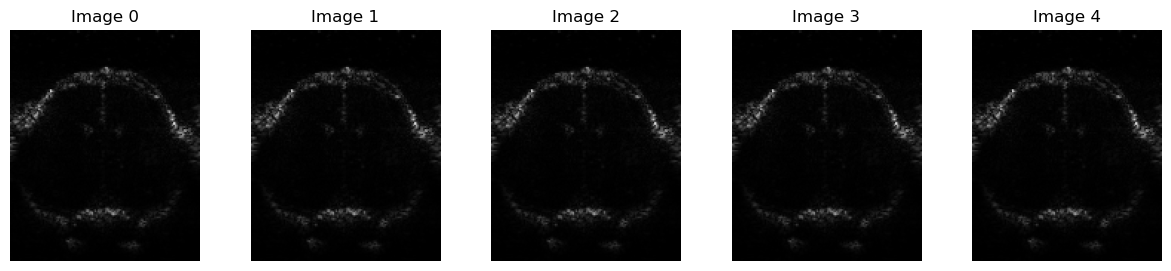

In [5]:
phase = False
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(np.abs(rat_brain[:,:,i]), cmap='gray')
    if phase :
        ax[i].imshow(np.angle(rat_brain[:,:,i]), alpha=0.3, cmap='hsv')
    ax[i].set_title(f"Image {i}")
    ax[i].axis("off")
plt.show()

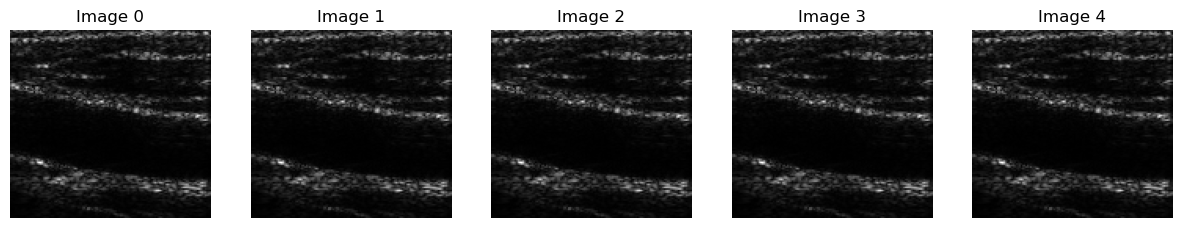

In [6]:
phase = False
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(np.abs(flow2[:, :,i]), cmap="gray")
    if (phase):
        ax[i].imshow(np.angle(flow2[:,:,i]), alpha=0.3, cmap='hsv')
    ax[i].set_title(f"Image {i}")
    ax[i].axis("off")
plt.show()

In [7]:
import numpy as np
def casorati_matrix(data):
    # Takes a 3D matrix of dimension (n_x, n_z, n_t) and returns a 2D matrix of dimension (n_x*n_z, n_t)
    n_x, n_z, n_t = data.shape
    data = np.reshape(data, (n_x*n_z, n_t))
    return data

def casorati_matrix_inverse(data, n_x, n_z):
    # Takes a 2D matrix of dimension (n_x*n_z, n_t) and returns a 3D matrix of dimension (n_x, n_z, n_t)
    n_t = data.shape[1]
    data = np.reshape(data, (n_x, n_z, n_t))
    return data

In [8]:
def SVD_filter(data, n_x, n_z, n_t, k):
    # Takes a 3D matrix of dimension (n_x, n_z, n_t) and returns a 3D matrix of dimension (n_x, n_z, n_t)
    # after applying SVD filter
    
    # Casorati matrix
    data_casorati = casorati_matrix(data)
    
    # Compute and diagonalize covariance matrix
    S = np.abs(data_casorati.conj().T @ data_casorati)
    eigenvalues,  eigenvectors = np.linalg.eig(S)

    # sort eigenvalues and eigenvectors
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]

    # Compute the projection matrix
    I_f = np.diag([0]*k + [1]*(n_t-k))
    data_projection = data_casorati @ eigenvectors @ I_f @ eigenvectors.conj().T
    print
    # reverse casorati 
    data_filtered = casorati_matrix_inverse(data_projection, n_x, n_z)
    
    explained_variance = np.cumsum(eigenvalues)/ np.sum(eigenvalues) * 100
    _ , ax = plt.subplots(1,2, figsize=(20,5))
    ax[0].plot(explained_variance); ax[0].set_title("Explained variance")
    ax[1].plot(eigenvalues, 'ro-'); ax[1].set_title("Eigen values")
    

    return data_filtered

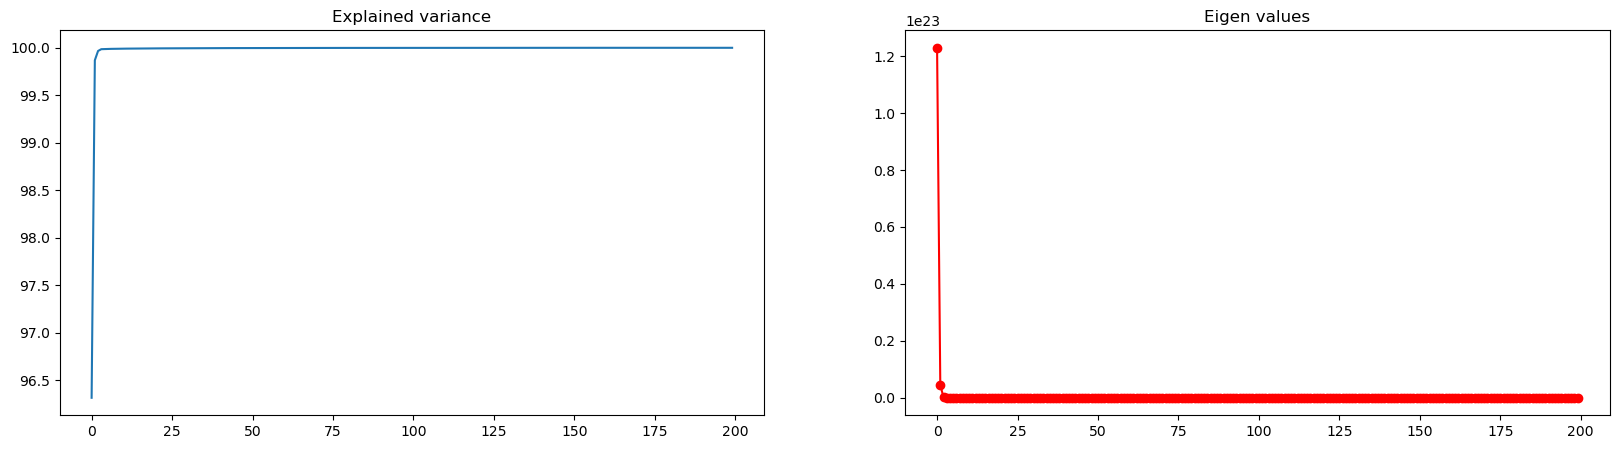

In [9]:
# Filter rat_brain
k=5
ratShape = rat_brain.shape
rat_brain_filtered = SVD_filter(rat_brain,ratShape[0], ratShape[1], ratShape[2] , k)


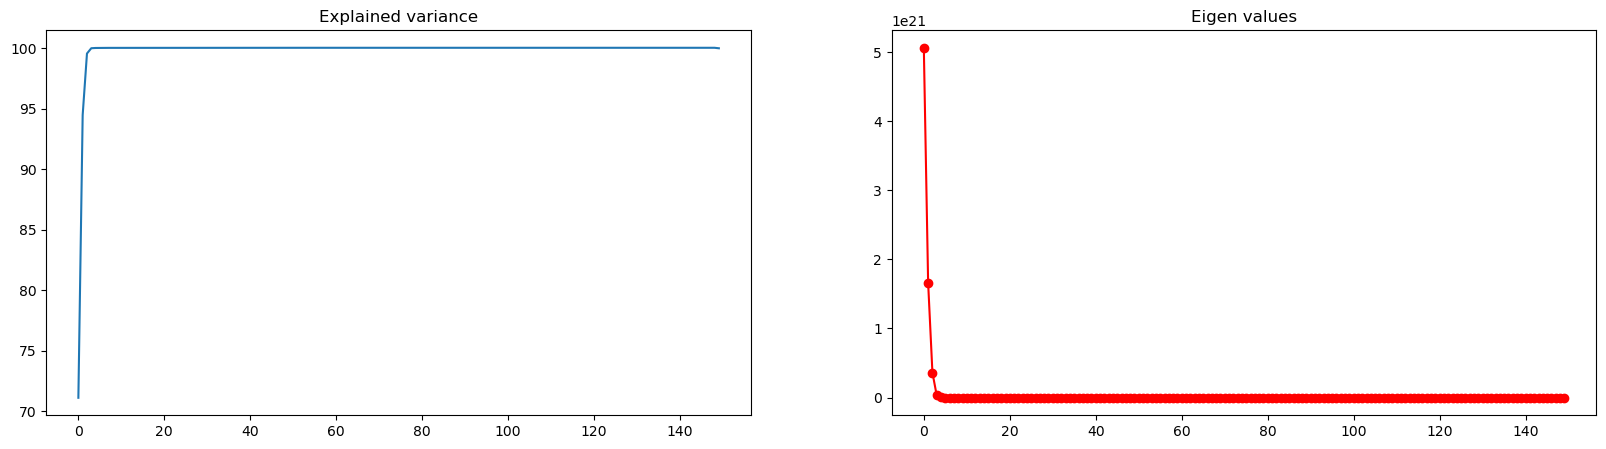

In [10]:
# filter flow2
k=5
flow2Shape = flow2.shape
flow2_filtered = SVD_filter(flow2, flow2Shape[0], flow2Shape[1], flow2Shape[2] , k)

Text(0.5, 1.0, 'SVD filter flow')

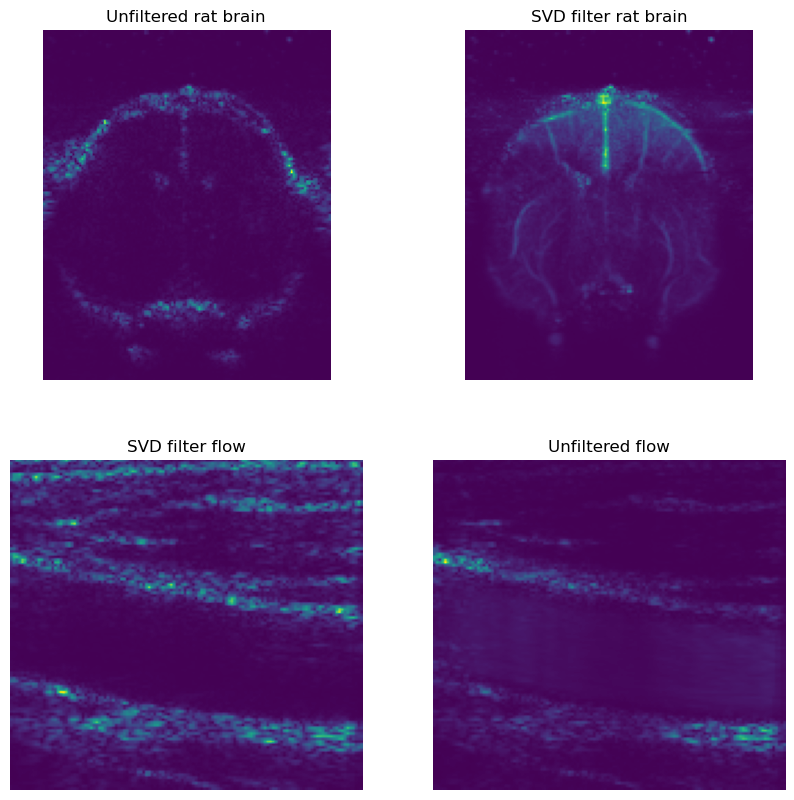

In [11]:
# Plot mean rat_brain and mean flow 2
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(np.mean(np.abs(rat_brain),axis=2)); ax[0,0].axis("off")
ax[0,0].set_title("Unfiltered rat brain")
ax[0,1].imshow(np.mean(np.abs(rat_brain_filtered), axis= 2)) ; ax[0,1].axis("off")
ax[0,1].set_title("SVD filter rat brain")
ax[1,1].imshow(np.mean(np.abs(flow2_filtered), axis= 2)); ax[1,1].axis("off")
ax[1,1].set_title("Unfiltered flow")
ax[1,0].imshow(np.mean(np.abs(flow2), axis=2)); ax[1,0].axis("off")
ax[1,0].set_title("SVD filter flow")

### Breakdown of SVD filter on rat brain

(19968, 200)

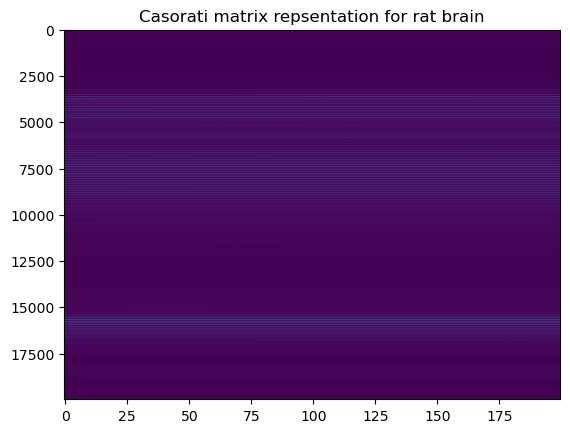

In [12]:
# Apply casorati_matrix rat_brain
rat_brain_casorati = casorati_matrix(rat_brain)
plt.imshow(np.abs(rat_brain_casorati), aspect="auto")
plt.title("Casorati matrix repsentation for rat brain")
rat_brain_casorati.shape

(200, 200)


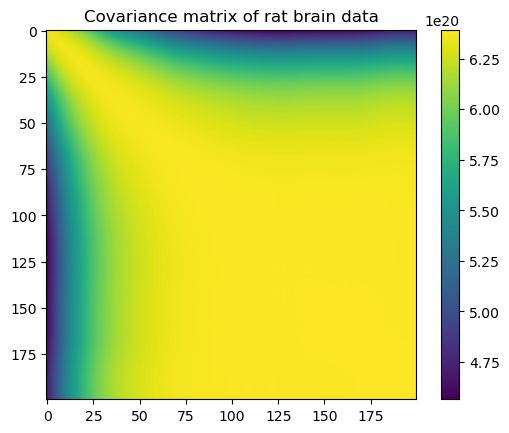

In [13]:
# compute covarance matrix
cov_rat_brain = np.absolute( rat_brain_casorati.conj().T @ rat_brain_casorati )
print(cov_rat_brain.shape)
# Plot covariance matrix of rat brain data
plt.imshow(cov_rat_brain)
plt.title("Covariance matrix of rat brain data")
plt.colorbar()
plt.show()

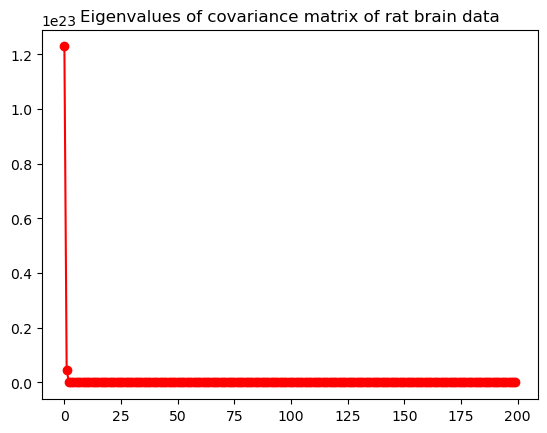

In [14]:
# Diagonalize the covariance matrix
eigvals_rat_brain, eigvecs_rat_brain = np.linalg.eig(cov_rat_brain)

# Sort eigenvalues and eigenvectors by decreasing eigenvalue
idx = eigvals_rat_brain.argsort()[::-1]
eigvals_rat_brain = eigvals_rat_brain[idx]
eigvecs_rat_brain = eigvecs_rat_brain[:,idx]

# Plot eigenvalues
plt.plot(eigvals_rat_brain[:], 'ro-')
plt.title("Eigenvalues of covariance matrix of rat brain data")
plt.show()

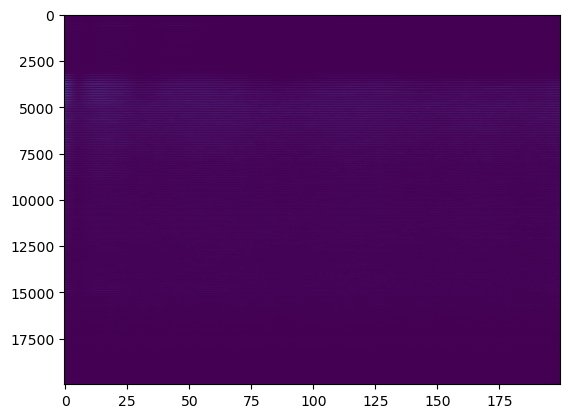

In [15]:
## Filter signal 
n = 5
I_f = np.diag([0 if i<n else 1 for i in  range(rat_brain.shape[2]) ])
rat_brain_casorati_filtered = rat_brain_casorati @ eigvecs_rat_brain @ I_f @ eigvecs_rat_brain.conj().T
plt.imshow(np.abs(rat_brain_casorati_filtered), aspect="auto")
rat_brain_filtered = casorati_matrix_inverse(rat_brain_casorati_filtered, rat_brain.shape[0], rat_brain.shape[1])

In [16]:
rat_magnitude = np.abs(rat_brain_filtered)
rat_magnitude = rat_magnitude / np.max(rat_magnitude)

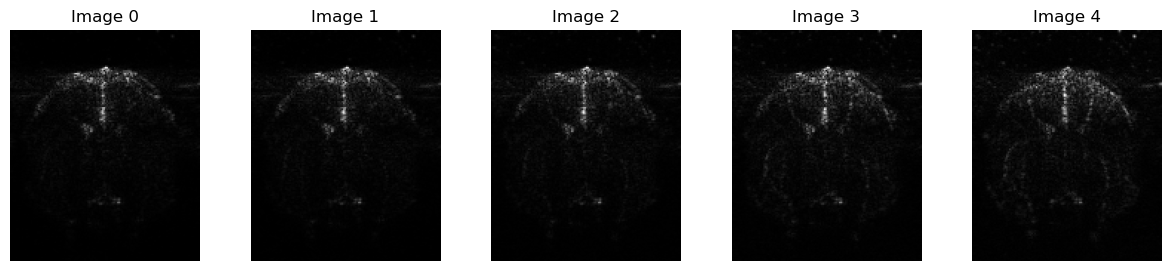

In [17]:
phase = False
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(rat_magnitude[:,:,i], cmap='gray')
    # if phase :
    #     ax[i].imshow(rat_phase[:,:,i], alpha=0.3, cmap='hsv')
    ax[i].set_title(f"Image {i}")
    ax[i].axis("off")
plt.show()

(136, 128)


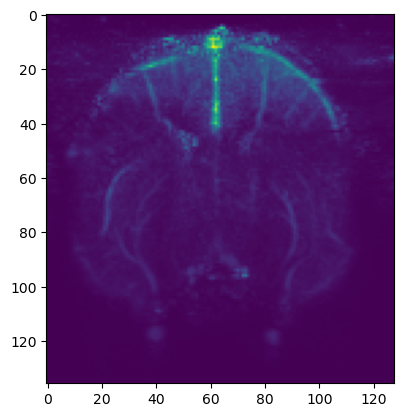

In [18]:
# Plot mean of filtered rat brain data
mean_rat = np.mean(rat_magnitude, axis=(2))[20:,:]
print(mean_rat.shape)
plt.imshow(mean_rat)

### Magnitude correction

(156, 200)


Text(0.5, 1.0, 'Mean horizontal pixel value')

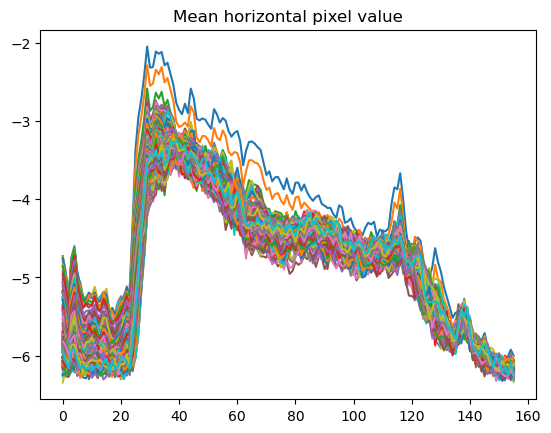

In [19]:
## Plot the log mean horizontal pixel value for each frame 
mean_per_line = np.mean(rat_magnitude[:,:,:], axis=(1)) 
print(mean_per_line.shape)  
plt.plot(np.log(mean_per_line))
plt.title("Mean horizontal pixel value")

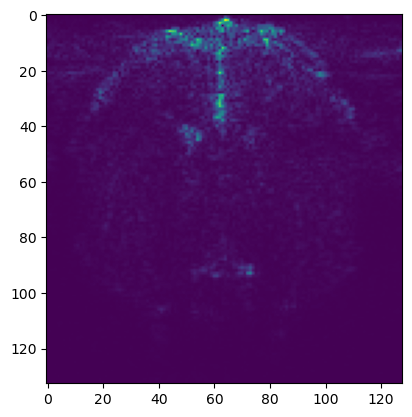

In [20]:
# Process the first rate image
rat_1 = rat_magnitude[23:,:,0]
plt.imshow(np.abs(rat_1))

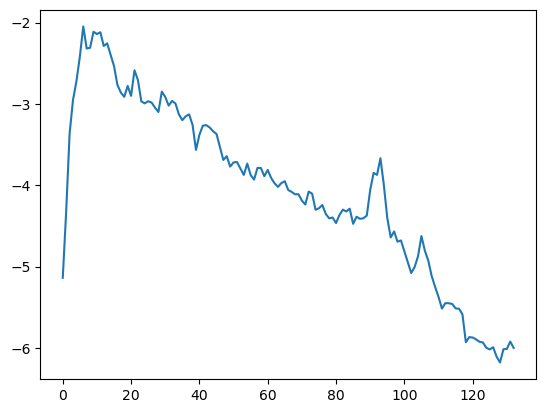

In [21]:
# Plot the line mean for rat 1
log_mean_rat_1 = np.log(np.mean(np.abs(rat_1), axis=1))
plt.plot(log_mean_rat_1)

(133,)


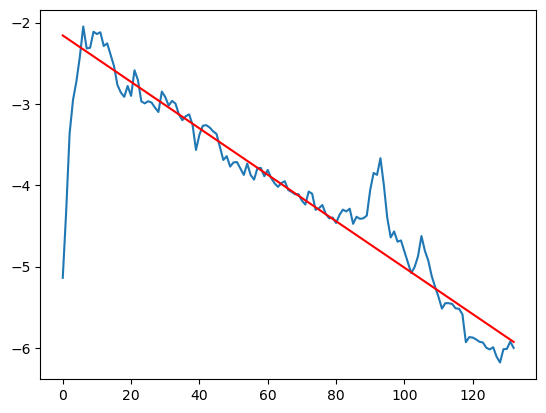

In [22]:
# remove the trend from the line mean
from sklearn.linear_model import HuberRegressor
X = np.arange(0,len(log_mean_rat_1)).reshape(-1,1)
y = log_mean_rat_1


reg = HuberRegressor().fit(X, y)
trend = reg.predict(X)
print(trend.shape)

plt.plot(log_mean_rat_1)
plt.plot(X, trend, color='red')


(133, 128)


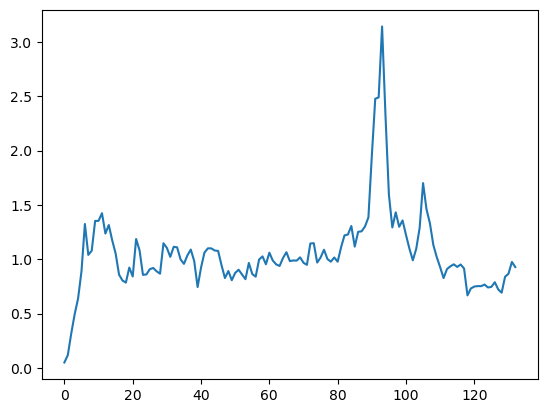

In [23]:
# rescale the rat 1 image
trend_tile = np.tile(trend[:,np.newaxis], rat_1.shape[1])
print(trend_tile.shape)
rat_1_rescaled = rat_1 / np.exp(trend_tile)
plt.plot(np.mean(rat_1_rescaled, axis=1))


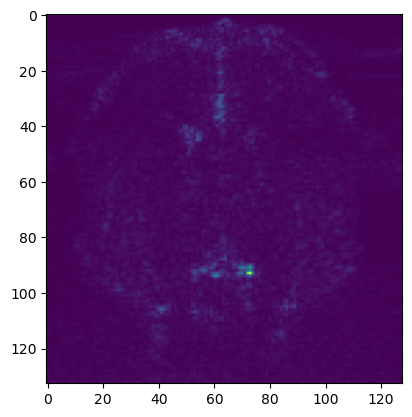

In [24]:
plt.imshow(np.abs(rat_1_rescaled))

In [25]:
def rescale_frame(frame):
    #estimate trend
    X = np.arange(0,len(frame)).reshape(-1,1)
    y = np.log(np.mean(frame, axis=1))
    reg = HuberRegressor().fit(X, y)
    trend = reg.predict(X)

    # rescale frame
    trend_tile = np.tile(trend[:,np.newaxis], frame.shape[1])
    frame_rescaled = frame / np.exp(trend_tile)
    
    return frame_rescaled

In [26]:
frame = rat_1
#estimate trend
X = np.arange(0,len(frame)).reshape(-1,1)
y = np.log(np.mean(frame, axis=1))
reg = HuberRegressor().fit(X, y)
trend = reg.predict(X)

print(y.shape)

(133,)


In [27]:
# Rescale all rat brain images
rat_magnitude_rescaled = np.zeros(rat_magnitude[23:,:,:].shape)
for i in range(rat_magnitude.shape[2]):
    rat_magnitude_rescaled[:,:,i] = rescale_frame(rat_magnitude[23:,:,i])

Text(0.5, 1.0, 'Rescaled mean')

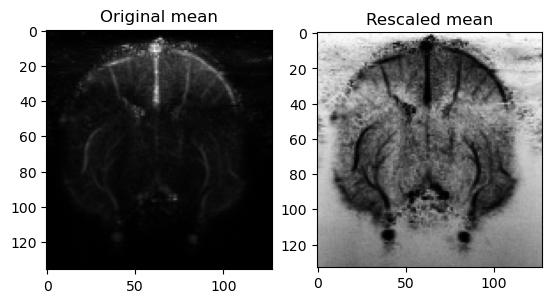

In [28]:
# plot mean rescaded rat brain
mean_pixel_brain_rescaled = np.mean(rat_magnitude_rescaled, axis=(2))
#plot rescaled mean vs original mean
fig, ax = plt.subplots(1, 2)
ax[0].imshow(mean_rat, cmap='gray')
ax[0].set_title("Original mean")
ax[1].imshow(np.exp(-mean_pixel_brain_rescaled), cmap='gray')
ax[1].set_title("Rescaled mean")
